In [1]:
# Custom Params
IMAGE_SIZE = (128, 128)
TEST_DATA_SIZE = 0.2
DROPOUT_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 10

# Data Loading

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Path to the dataset
data_dir = '/kaggle/input/plantdisease/PlantVillage'

# Classes (labels) based on folder names in the dataset
classes = [plant for plant in os.listdir("/kaggle/input/plantdisease/PlantVillage") if plant.startswith("Tomato")]
print(classes)

# Mapper dictionary
class_mapper = {
    'Tomato_Leaf_Mold': 'Leaf Mold',
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 'Yellow Leaf Curl Virus',
    'Tomato_Bacterial_spot': 'Bacterial Spot',
    'Tomato_Septoria_leaf_spot': 'Septoria Leaf Spot',
    'Tomato_healthy': 'Healthy',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'Spider Mites',
    'Tomato_Early_blight': 'Early Blight',
    'Tomato__Target_Spot': 'Target Spot',
    'Tomato_Late_blight': 'Late Blight',
    'Tomato__Tomato_mosaic_virus': 'Mosaic Virus'
}

['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus']


In [3]:
X = []
y = []

for label, class_name in tqdm(enumerate(classes)):
    class_dir = os.path.join(data_dir, class_name)
    label_name = class_mapper[class_name]
    
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMAGE_SIZE)           # Resize image: Preprocessing
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB: Preprocessing
            X.append(img)
            y.append(label_name)

# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data loaded successfully: {X.shape[0]} images with size {X.shape[1:]}")

10it [03:16, 19.65s/it]


Data loaded successfully: 16011 images with size (128, 128, 3)


# Data Exploration

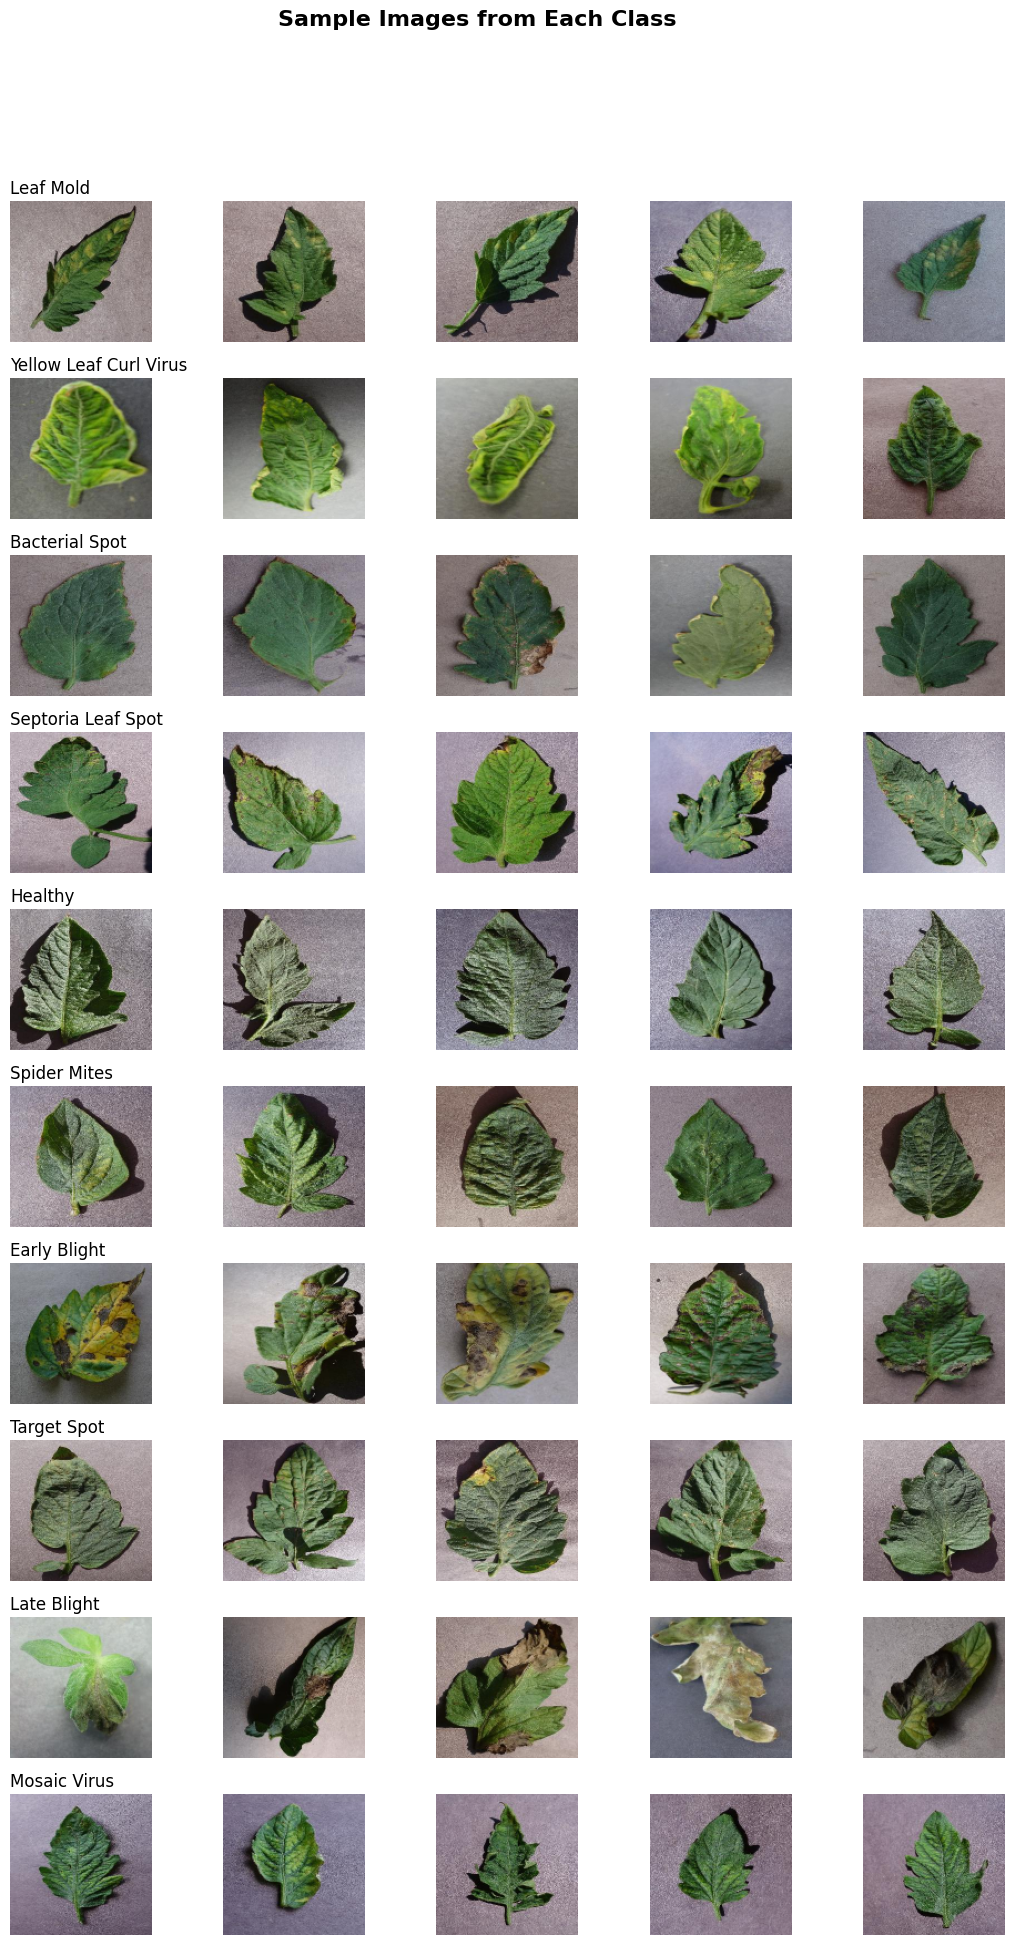

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict

samples_per_class = 5
fig, axes = plt.subplots(len(class_mapper), samples_per_class, figsize=(12, len(class_mapper) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16, weight='bold', y=1.02)

# Indices by class for easy access
class_indices = defaultdict(list)
for idx, label in enumerate(y):
    class_indices[label].append(idx)

# Display images
for class_idx, (class_name, indices) in enumerate(class_indices.items()):
    selected_indices = np.random.choice(indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X[idx])
        ax.axis("off")

    # Label as a title for each row
    axes[class_idx, 0].set_title(class_name, fontsize=12, loc='left', pad=5)

# Adjusting layout for better spacing
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


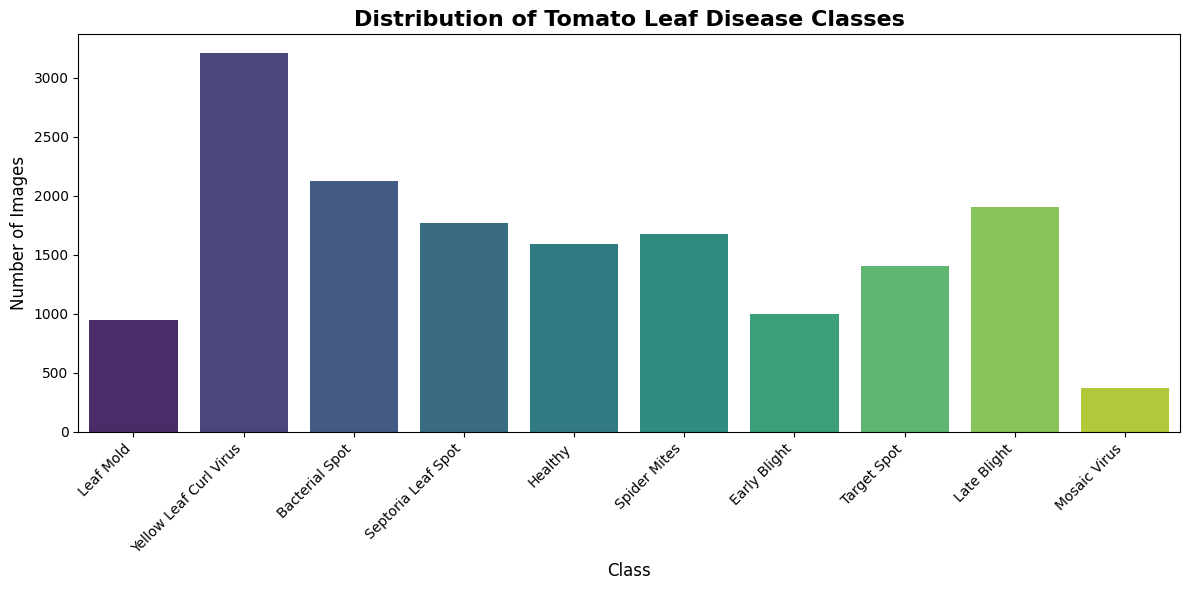

In [5]:
import seaborn as sns
from collections import Counter

# Occurrences of each class in y
class_counts = Counter(y)

# Extracting class names and counts for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")

# Add titles and labels
plt.title("Distribution of Tomato Leaf Disease Classes", fontsize=16, weight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Encoding y
y_encoded = [classes.index(i) for i in y]

# Spliting data into 80% training and 20% testing: Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=TEST_DATA_SIZE, 
                                                    stratify=y, random_state=42)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize images: Preprocessing
    
    rotation_range=20,              # Rotate images up to 20 degrees
    width_shift_range=0.1,          # Shift images horizontally by 10%
    height_shift_range=0.1,         # Shift images vertically by 10%
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in on images
    horizontal_flip=True,           # Randomly flip images horizontally
    fill_mode='nearest'             # Fill pixels created by transformation
)

# Generator for test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Training generator
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,        # Grouping: Preprocessing
    shuffle=True                  # Shuffle the data
)

# Testing generator
test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Summary
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 12808, Testing samples: 3203


# CNN Model

In [8]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer with units equal to the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Path to save the best model
checkpoint_path = "best_model_cnn.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [10]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734769814.362596      68 service.cc:145] XLA service 0x79d628004d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734769814.362672      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/400 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.1389 - loss: 2.5811

I0000 00:00:1734769818.393086      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/400 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.2588 - loss: 2.1073

I0000 00:00:1734769832.986476      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 64 bytes spill stores, 64 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3934 - loss: 1.7330
Epoch 1: val_loss improved from inf to 0.75074, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.3937 - loss: 1.7321 - val_accuracy: 0.7322 - val_loss: 0.7507
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6875 - loss: 0.7640

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.75074
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6875 - loss: 0.7640 - val_accuracy: 0.3333 - val_loss: 1.2975
Epoch 3/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7468 - loss: 0.7340
Epoch 3: val_loss improved from 0.75074 to 0.51452, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.7469 - loss: 0.7338 - val_accuracy: 0.8156 - val_loss: 0.5145
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8125 - loss: 0.5812
Epoch 4: val_loss improved from 0.51452 to 0.03500, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.8125 - loss: 0.5812 - val_accuracy: 1.0000 - val_loss: 0.0350
Epoch 5/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7962 - loss: 0.5776
Epoch 5: val_loss did not improve from 0.03500
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.7963 - loss: 0.5774 - val_accuracy: 0.8606 - val

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import random

def evaluate_model(y_true, y_pred, class_names, images):
    # Calculate and print accuracy, precision, recall, F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # ROC Curve for each class
    plt.figure(figsize=(10, 7))
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=len(class_names))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title("ROC Curve for Each Class")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    
    # Display 3x3 grid of random samples with actual and predicted labels
    plt.figure(figsize=(8, 8))
    indices = random.sample(range(len(images)), 9)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        actual_label = class_names[y_true[idx]]
        predicted_label = class_names[y_pred[idx]]
        ax.set_title(f"Act: {actual_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.suptitle("3x3 Random Samples with Actual and Predicted Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.90      0.72      0.80       190
Yellow Leaf Curl Virus       0.98      0.93      0.95       642
        Bacterial Spot       0.95      0.83      0.89       426
    Septoria Leaf Spot       0.85      0.92      0.88       354
               Healthy       0.92      0.99      0.96       318
          Spider Mites       0.80      0.79      0.80       335
          Early Blight       0.70      0.70      0.70       200
           Target Spot       0.67      0.89      0.76       281
           Late Blight       0.91      0.89      0.90       382
          Mosaic Virus       0.88      0.85      0.86        75

              accuracy                           0.87      3203
             macro avg       0.86      0.85      0.85      3203
          weighted avg       0.88      0.8

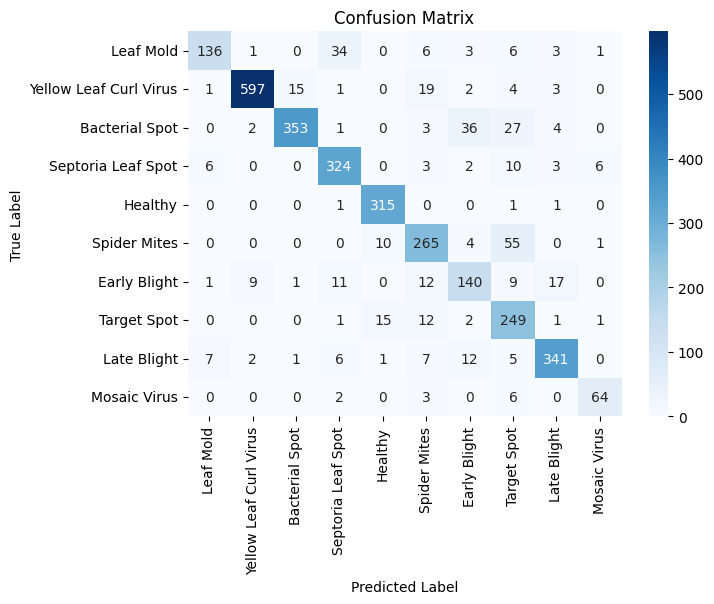

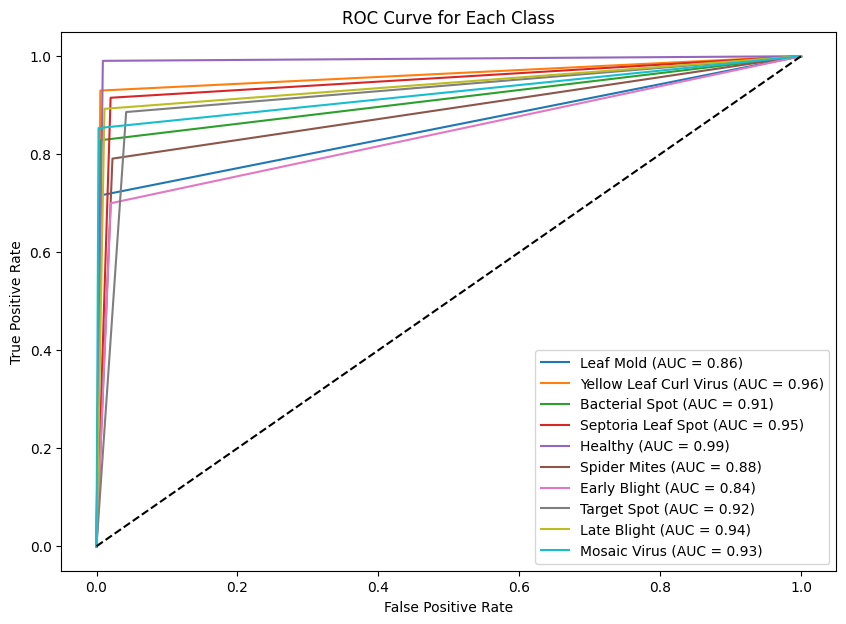

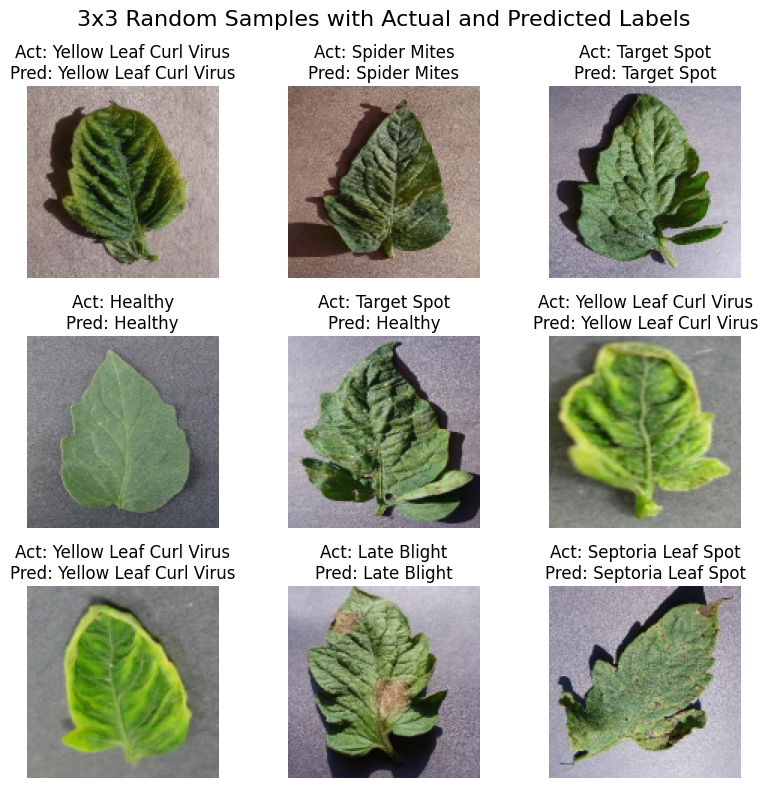

In [12]:
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Generate predictions
evaluate_model(y_test, y_pred, classes, X_test)

# 2) Transfer Learning Models

## a) Mobilenet (Non Trainable)

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model's layers (so they are not trained)
base_model.trainable = False

# Add custom layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Path to save the best model
checkpoint_path = "best_model_TL_NON_Trainable.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [15]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6272 - loss: 1.1201
Epoch 1: val_loss improved from inf to 0.62409, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 123ms/step - accuracy: 0.6277 - loss: 1.1186 - val_accuracy: 0.7794 - val_loss: 0.6241
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7500 - loss: 0.6917

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.62409
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7500 - loss: 0.6917 - val_accuracy: 0.6667 - val_loss: 1.3240
Epoch 3/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8127 - loss: 0.5231
Epoch 3: val_loss improved from 0.62409 to 0.57234, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.8128 - loss: 0.5229 - val_accuracy: 0.8050 - val_loss: 0.5723
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8750 - loss: 0.4191
Epoch 4: val_loss improved from 0.57234 to 0.40508, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.8750 - loss: 0.4191 - val_accuracy: 0.6667 - val_loss: 0.4051
Epoch 5/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8465 - loss: 0.4389
Epoch 5: val_loss did not improve from 0.40508
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - accuracy: 0.8466 - loss: 0.4388 - va

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Accuracy: 0.86
Precision: 0.88
Recall: 0.86
F1 Score: 0.87

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.93      0.80      0.86       190
Yellow Leaf Curl Virus       0.99      0.97      0.98       642
        Bacterial Spot       0.90      0.95      0.92       426
    Septoria Leaf Spot       0.86      0.88      0.87       354
               Healthy       0.99      0.68      0.81       318
          Spider Mites       0.68      0.96      0.80       335
          Early Blight       0.69      0.70      0.70       200
           Target Spot       0.74      0.69      0.71       281
           Late Blight       0.96      0.88      0.92       382
          Mosaic Virus       0.80      0.97      0.88        75

              accuracy                           0.86      3203
             macro avg       0.85      0.85      0.84      3203
          weighted avg       0.88      0.

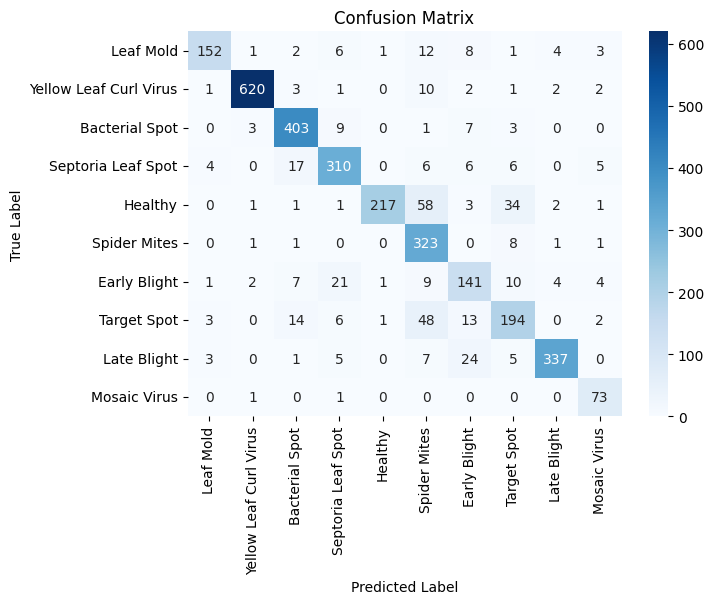

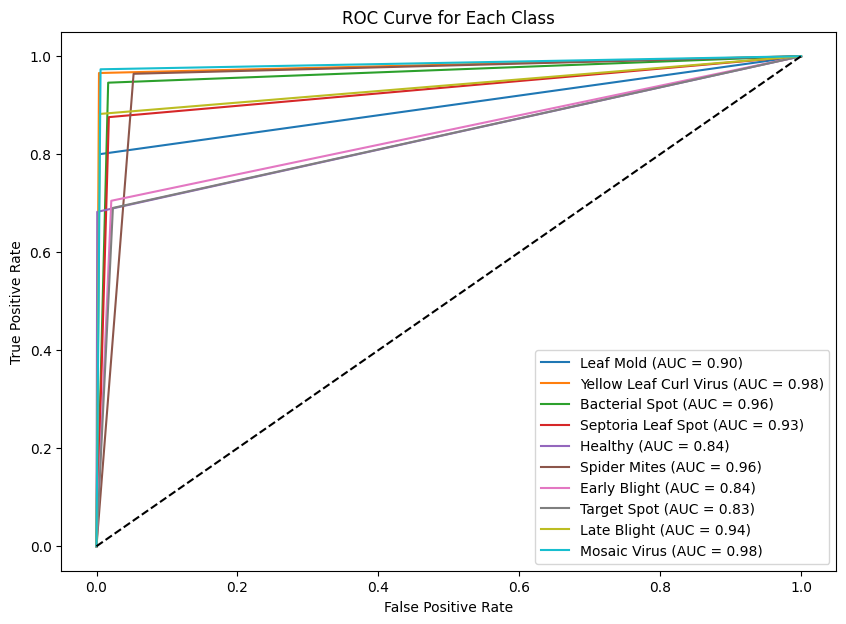

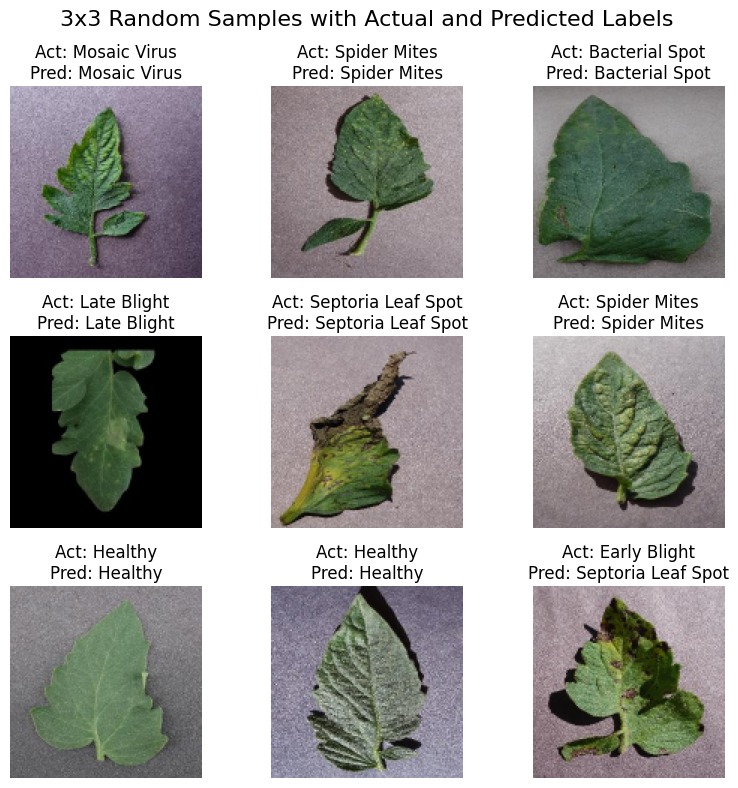

In [16]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Get predicted class indices
evaluate_model(y_test, y_pred, classes, X_test)

### b) Mobilenet (Trainable)

In [17]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model's layers
base_model.trainable = True

# Add custom layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
# Path to save the best model
checkpoint_path = "best_model_TL_Trainable.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [19]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10
323/400 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.7398 - loss: 0.8096

I0000 00:00:1734770383.630666      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 288 bytes spill stores, 288 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7574 - loss: 0.7584
Epoch 1: val_loss improved from inf to 12.69359, saving model to best_model_TL_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 101s 156ms/step - accuracy: 0.7576 - loss: 0.7578 - val_accuracy: 0.1109 - val_loss: 12.6936
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9375 - loss: 0.1912

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 12.69359 to 11.06597, saving model to best_model_TL_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9375 - loss: 0.1912 - val_accuracy: 0.3333 - val_loss: 11.0660
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9066 - loss: 0.3148
Epoch 3: val_loss did not improve from 11.06597
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 118ms/step - accuracy: 0.9067 - loss: 0.3147 - val_accuracy: 0.1441 - val_loss: 13.0554
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9375 - loss: 0.1495
Epoch 4: val_loss did not improve from 11.06597
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.9375 - loss: 0.1495 - val_accuracy: 0.0000e+00 - val_loss: 18.6349
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9401 - loss: 0.2079
Epoch 5: val_loss did not improve from 11.06597
400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 119ms/step - accuracy: 0.9401 - loss: 0.2078 - val_accuracy: 0.1163 - val_loss: 17.0403
Epoch 6/

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Accuracy: 0.21
Precision: 0.07
Recall: 0.21
F1 Score: 0.08

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.00      0.00      0.00       190
Yellow Leaf Curl Virus       0.00      0.00      0.00       642
        Bacterial Spot       0.00      0.00      0.00       426
    Septoria Leaf Spot       0.21      0.94      0.35       354
               Healthy       0.00      0.00      0.00       318
          Spider Mites       0.00      0.00      0.00       335
          Early Blight       0.00      0.00      0.00       200
           Target Spot       0.00      0.00      0.00       281
           Late Blight       0.19      0.82      0.31       382
          Mosaic Virus       0.90      0.25      0.40        75

              accuracy                           0.21      3203
             macro avg       0.13      0.20      0.11      3203
          weighted avg       0.07      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

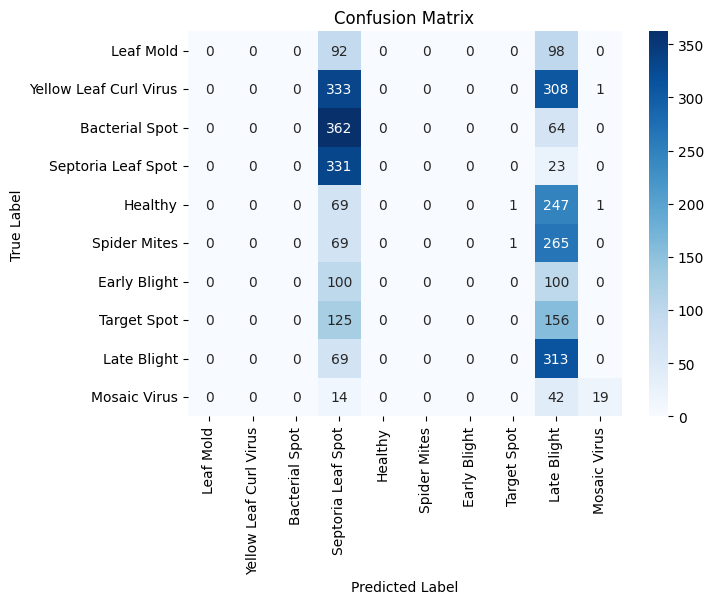

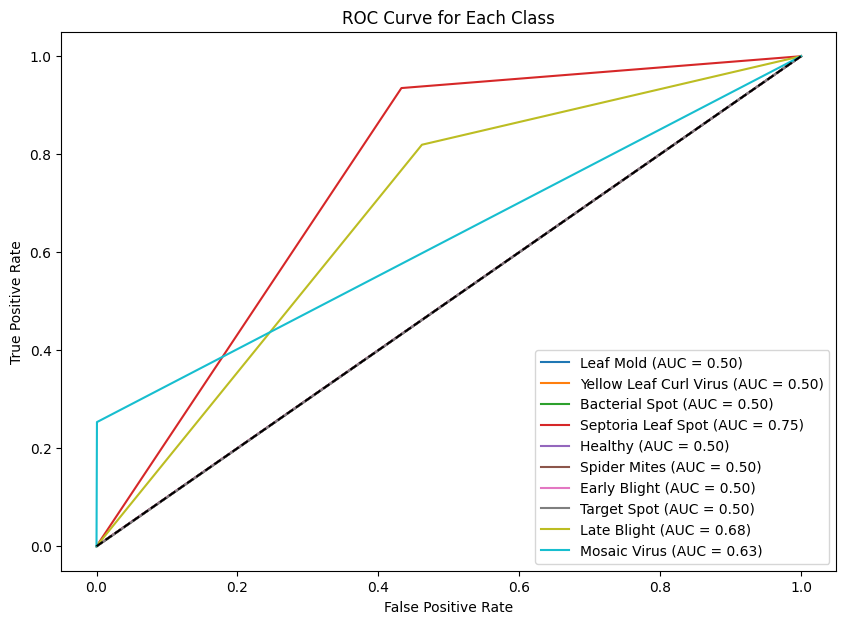

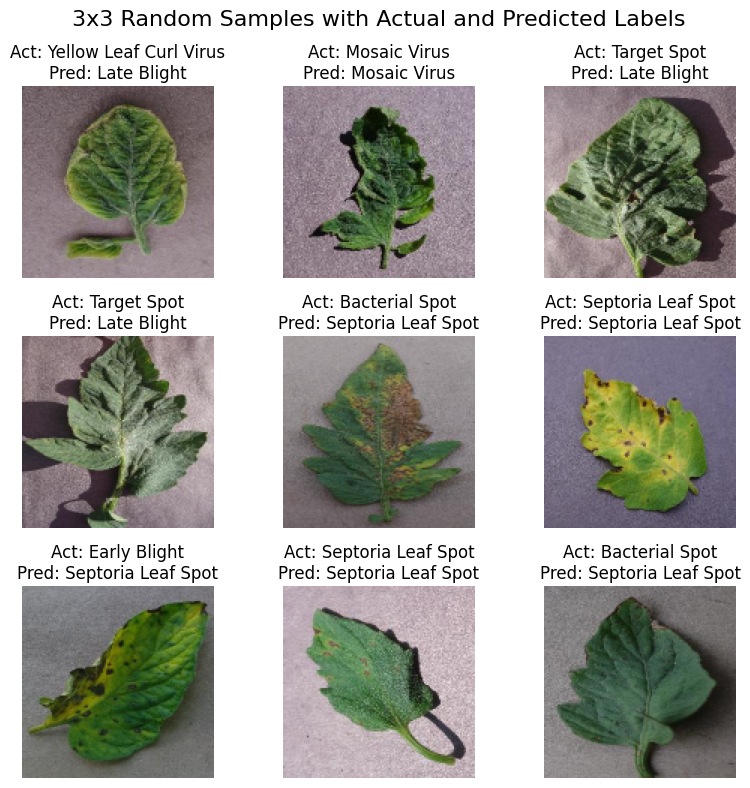

In [20]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Get predicted class indices
evaluate_model(y_test, y_pred, classes, X_test)